# Overview
The purpose of this kernel is to take a look at the data, come up with some insights, and attempt to create a predictive model or two. This notebook is still very raw. I will work on it as my very limited time permits, and hope to expend it in the upcoming days and weeks.

NB: Most of the feature engineering and some of the modeling is based on Peter Hurford's excellent kernel , and another one by Konrad Banachevitz.

# Packages
First, let's load a few useful Python packages. This section will keep growing in subsequent versions of this EDA.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import Ridge
import time
from sklearn import preprocessing
import warnings
import datetime
warnings.filterwarnings('ignore')
import gc
from tqdm import tqdm

from scipy.stats import describe
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

Let's see what files we have in the input directory.

In [3]:
import os
print(os.listdir())

['.ipynb_checkpoints', 'baseline_lgb.csv', 'Data_Dictionary.xlsx', 'E.D.A and Baseline.ipynb', 'EloDa with Feature Engineering and Stacking.ipynb', 'historical_transactions.csv', 'LGBM.ipynb', 'merchants.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'test.csv', 'train.csv']


We see that in addition to the usual,train, test and sample_submission files, we also have merchants, historical_transactions, new_merchant_transactions, and even one (HORROR!!!) excel file - Data_Dictionary. The names of the files are pretty self-explanatory, but we'll take a look at them and explore them. First, let's look at the train and test files.

In [4]:
train = pd.read_csv('train.csv', parse_dates = ['first_active_month'])
test = pd.read_csv('test.csv', parse_dates = ['first_active_month'])
print("{} observations and {} features in train set.".format(train.shape[0],train.shape[1]))
print("{} observations and {} features in test set.".format(test.shape[0],test.shape[1]))

201917 observations and 6 features in train set.
123623 observations and 5 features in test set.


In [5]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [6]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


Seems fairly straightfoward - just ID, first active months, three anonimous features, and target for train set

Let's take a look at the target variable:

In [7]:
train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

Seems like a very wide range of values, relatively speaking. Let's take a look at the graph of the distribution.

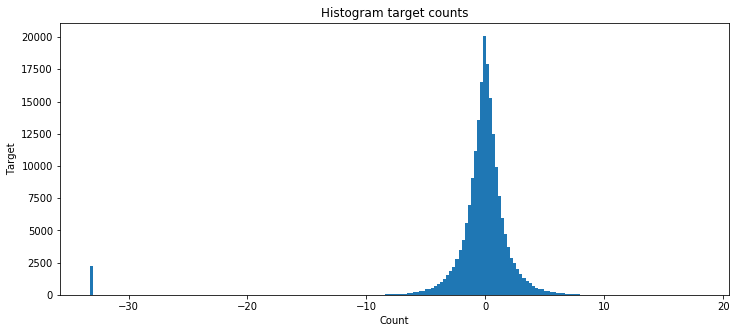

In [8]:
plt.figure(figsize=(12, 5))
plt.hist(train.target.values, bins=200)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

Seems like a pretty nice normal-looking distribution, except for the few anomalous elements at the far left. They will have to be dealt separately.

Lets look at the 'violin' version of the same plot.

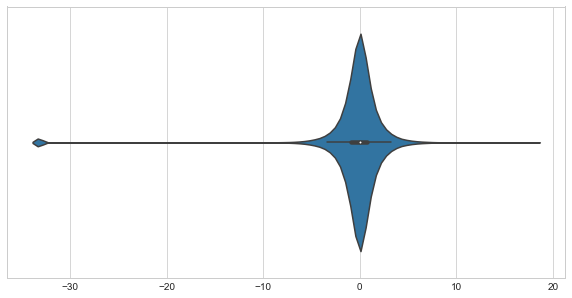

In [9]:
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
sns.violinplot(x=train.target.values)
plt.show()

Yup, there is that little bump on the far left again.

Let's now look at the distribution of various 'features'

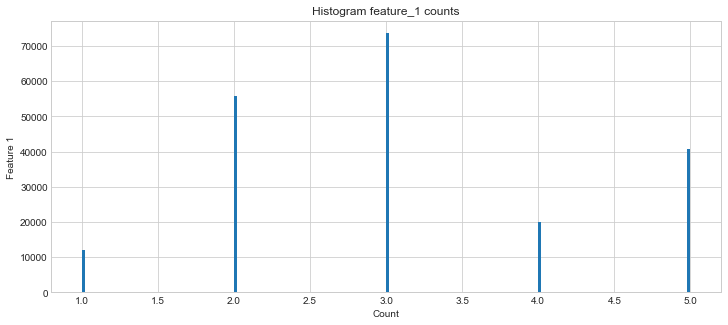

In [10]:
plt.figure(figsize=(12, 5))
plt.hist(train.feature_1.values, bins=200)
plt.title('Histogram feature_1 counts')
plt.xlabel('Count')
plt.ylabel('Feature 1')
plt.show()

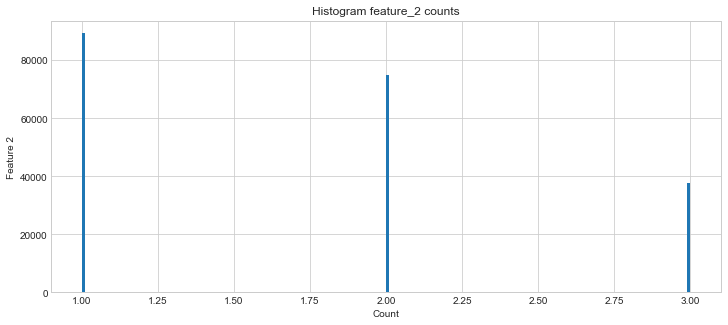

In [11]:
plt.figure(figsize=(12, 5))
plt.hist(train.feature_2.values, bins=200)
plt.title('Histogram feature_2 counts')
plt.xlabel('Count')
plt.ylabel('Feature 2')
plt.show()

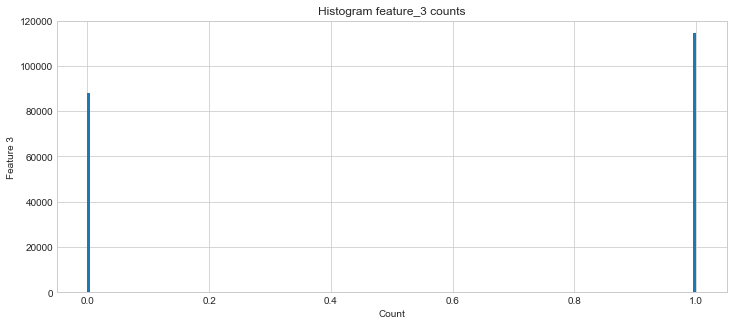

In [12]:
plt.figure(figsize=(12, 5))
plt.hist(train.feature_3.values, bins=200)
plt.title('Histogram feature_3 counts')
plt.xlabel('Count')
plt.ylabel('Feature 3')
plt.show()

For now i am not including plots fot the test set.

A couple of things that stand out are:
* There are only a handful of values for each of the three features.
* They are discrete.
* They area relatively eavenly distributed.

All of this suggests that these features are categorical and have been label-encoded.

Here is a gratuitous embedding of Youtube video for no reason

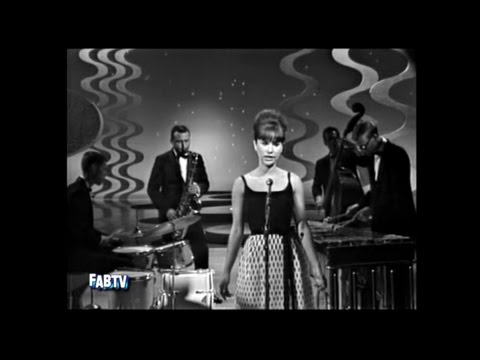

In [13]:
from IPython.display import YouTubeVideo
YouTubeVideo('UJkxFhFRFDA')

In [14]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
hist_trans = pd.read_csv('historical_transactions.csv')
new_merchant_trans = pd.read_csv('new_merchant_transactions.csv')

In [15]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [16]:
new_merchant_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [17]:
for df in [hist_trans, new_merchant_trans]:
    df['category_2'].fillna(1.0, inplace=True)
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [18]:
def get_new_columns(name, aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [19]:
for df in [hist_trans,new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [36]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    hist_trans[col+'_mean'] = hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
hist_trans_group = hist_trans.groupby('card_id').agg(aggs)
hist_trans_group.columns = new_columns
hist_trans_group.reset_index(drop=False,inplace=True)
hist_trans_group['hist_purchase_date_diff'] = (hist_trans_group['hist_purchase_date_max'] - hist_trans_group['hist_purchase_date_min']).dt.days
hist_trans_group['hist_purchase_date_average'] = hist_trans_group['hist_purchase_date_diff']/hist_trans_group['hist_card_id_size']
hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - hist_trans_group['hist_purchase_date_max']).dt.days
train = train.merge(hist_trans_group,on='card_id',how='left')
test = test.merge(hist_trans_group,on='card_id',how='left')
del hist_trans_group;gc.collect();gc.collect()

0

In [38]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    new_merchant_trans[col+'_mean'] = new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
hist_trans_group = new_merchant_trans.groupby('card_id').agg(aggs)
hist_trans_group.columns = new_columns
hist_trans_group.reset_index(drop=False,inplace=True)
hist_trans_group['new_hist_purchase_date_diff'] = (hist_trans_group['new_hist_purchase_date_max'] - hist_trans_group['new_hist_purchase_date_min']).dt.days
hist_trans_group['new_hist_purchase_date_average'] = hist_trans_group['new_hist_purchase_date_diff']/hist_trans_group['new_hist_card_id_size']
hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - hist_trans_group['new_hist_purchase_date_max']).dt.days
train = train.merge(hist_trans_group,on='card_id',how='left')
test = test.merge(hist_trans_group,on='card_id',how='left')
del hist_trans_group;gc.collect();gc.collect()

0

In [40]:
del hist_trans; gc.collect()
del new_merchant_trans; gc.collect()
train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,-0.550160,-0.592993,54.0,2.347826,269.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,-0.550160,-0.606486,56.0,9.333333,300.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,-0.549015,-0.592993,0.0,0.000000,270.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,-0.556518,-0.604559,41.0,5.857143,280.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,-0.555446,-0.588217,57.0,1.583333,270.0


In [41]:
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [42]:
for df in [train,test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([f])['outliers'].mean()
    train[f] = train[f].map(order_label)
    test[f] = test[f].map(order_label)

In [44]:
train_columns = [c for c in train.columns if c not in ['card_id', 'first_active_month', 'target', 
                                                      'outliers']]
target = train['target']
del train['target']

In [52]:
train[train_columns].to_csv('train_3.csv', index=False)
test[train_columns].to_csv('test_3.csv', index=False)

In [60]:
param = {'num_leaves': 31,
        'min_data_in_leaf': 30,
        'objective': 'regression',
        'max_depth': -1,
        'learning_rate': 0.01,
        'min_child_samples': 20,
        'boosting': 'gbdt',
        'feature_fraction': 0.9,
        'bagging_freq': 1,
        'bagging_fraction': 0.9,
        'bagging_seed': 11,
        'metric': 'rmse',
        'lambda_l1': 0.1,
        'verbosity': -1,
        'nthread': 4,
        'random_state': 4590}

oof_lgb_3 = np.zeros(len(train))
predictions_lgb_3 = np.zeros(len(test))
start = time.time()

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold n {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label = target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label = target.iloc[val_idx])
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                   verbose_eval = 100, early_stopping_rounds = 200)
    
    oof_lgb_3[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration = clf.best_iteration)
    
    predictions_lgb_3 += clf.predict(test[train_columns], num_iteration = clf.best_iteration)/ folds.n_splits
    
np.save('off_lgb_3', oof_lgb_3)
np.save('predictions_lgb_3', predictions_lgb_3)
print('CV score: ', mean_squared_error(oof_lgb_3, target)**0.5)

fold n 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.66534	valid_1's rmse: 3.71728
[200]	training's rmse: 3.58807	valid_1's rmse: 3.68652
[300]	training's rmse: 3.53968	valid_1's rmse: 3.67504
[400]	training's rmse: 3.50387	valid_1's rmse: 3.66793
[500]	training's rmse: 3.47443	valid_1's rmse: 3.66335
[600]	training's rmse: 3.44893	valid_1's rmse: 3.66059
[700]	training's rmse: 3.4271	valid_1's rmse: 3.65933
[800]	training's rmse: 3.40641	valid_1's rmse: 3.65816
[900]	training's rmse: 3.3879	valid_1's rmse: 3.65677
[1000]	training's rmse: 3.37007	valid_1's rmse: 3.65675
[1100]	training's rmse: 3.35384	valid_1's rmse: 3.65662
[1200]	training's rmse: 3.33812	valid_1's rmse: 3.65642
[1300]	training's rmse: 3.32295	valid_1's rmse: 3.65622
[1400]	training's rmse: 3.30803	valid_1's rmse: 3.65623
[1500]	training's rmse: 3.29395	valid_1's rmse: 3.6566
Early stopping, best iteration is:
[1351]	training's rmse: 3.31482	valid_1's rmse: 3.65597
fold n 1


In [63]:
xgb_params = {'eta' : 0.005, 'max_depth': 10, 'subsample': 0.8,
             'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True,
             'n_treads': 4}

oof_xgb_3 = np.zeros(len(train))
predictions_xgb_3 = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print('-')
    print('Fold : ', fold_ + 1)
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx][train_columns], label = target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx][train_columns], label = target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print('xgb ' + str(fold_) + '-'*50 )
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50,
                         verbose_eval=1000)
    oof_xgb_3[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][train_columns]), ntree_limit = xgb_model.best_ntree_limit+50)
    predictions_xgb_3 += xgb_model.predict(xgb.DMatrix(test[train_columns]), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits

np.save('oof_xgb_3', oof_xgb_3)
np.save('predictions_xgb_3', predictions_xgb_3)
print(np.sqrt(mean_squared_error(target.values, oof_xgb_3)))

-
Fold :  1
xgb 0--------------------------------------------------
[0]	train-rmse:3.94768	valid-rmse:3.95418
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[723]	train-rmse:2.83852	valid-rmse:3.6579

-
Fold :  2
xgb 1--------------------------------------------------
[0]	train-rmse:3.94763	valid-rmse:3.95344
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[909]	train-rmse:2.74934	valid-rmse:3.66429

-
Fold :  3
xgb 2--------------------------------------------------
[0]	train-rmse:3.95038	valid-rmse:3.94162
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.


KeyboardInterrupt: 

In [ ]:
train_stack = np.vstack([oof_lgb_3, oof_xgb_3]).transpose()
test_stack = np.vstack([predictions_lgb_3, predictions_xgb_3]).transpose()

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, train['outliers'].values)):
    print("fold n : ", fold_ + 1)
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf = Ridge(alpha=1)
    clf.fit(trn_data, trn_y)
    
    oof[val_idx] = clf.predict(val_data)
    predictions += clf.predict(test_stack) / folds.n_xplits
    
print(np.sqrt(mean_squared_error(target.values, oof)))

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = predictions
sample_submission.to_csv('stacking_xgb_lgb_ridge', index = False)